# **Bloque 1. Código**

**1.1 Importación de los Paquetes Necesarios**

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.6 MB/s eta 0:00:00


In [ ]:
# Importamos paquetes
!pip install optuna
!pip install tensorflow
!pip install onedrivedownloader
from onedrivedownloader import download
import os
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

import keras_tuner as kt
from tensorflow.keras.applications import VGG19, EfficientNetV2S, InceptionResNetV2, Xception, ResNet50V2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad, SGD

import plotly.express as px
from sklearn.metrics import classification_report
import pandas as pd

from ipywidgets import interact
import ipywidgets as widgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.6 MB/s eta 0:00:00


**1.2 Importación de los Datos** <p>
En esta actividad tenemos que clasificar un conjunto de imágenes de especies marinas en 23 clases. Para empezar, descargamos las carpetas que contienen las imágenes de los distintos animales marinos.

In [ ]:
url = 'https://universidadfv-my.sharepoint.com/:u:/g/personal/alberto_desantos_ufv_es/EUbtnnHM19hOv-4_Upd2hiUB_Dk-hpwhXsnegWNixX05oA?e=HDV6lW'

download(url = url, filename = 'archivo.zip', unzip=True, force_download=True, clean=True)

100%|██████████| 327M/327M [00:09<00:00, 33.6MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 13711/13711 [00:03<00:00, 4054.71it/s]


''

**1.3 Preparación de los Datos** <p>
Para mantener los datos bien organizados, creamos una carpeta llamada *Marine*, en la que almacenamos exclusivamente las imágenes relacionadas con las especies marinas. De esta forma, facilitamos el acceso y la gestión de los datos durante el proceso de clasificación.

In [ ]:
# Definimos la carpeta target
parent_folder = '/content/Marine'

# Procuramos crear la carpeta Marine si no existe ya
if not os.path.exists(parent_folder):
    os.mkdir(parent_folder)
    print(f"Created: {parent_folder}")
else:
    print(f"{parent_folder} already exists.")

# Listamos todas las carpetas de animales en /content
current_folders = [f for f in os.listdir('/content') if os.path.isdir(os.path.join('/content', f))]
# Filter out system folders like 'sample_data' or 'Marine' itself (optional)
wildlife = [f for f in current_folders if f not in ['.config', 'sample_data', 'Marine']]

# Movemos cada carpeta de animal a la carpeta Marine
for animal in wildlife:
    source_path = os.path.join('/content', animal)
    destination_path = os.path.join(parent_folder, animal)
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        print(f"Moved: {source_path} to {destination_path}")
    else:
        print(f"Source folder not found: {source_path}")

# Verificamos el contenido de la carpeta Marine
print("Subfolders in Marine:", os.listdir(parent_folder))

Created: /content/Marine
Moved: /content/Lobster to /content/Marine/Lobster
Moved: /content/Starfish to /content/Marine/Starfish
Moved: /content/Sea Urchins to /content/Marine/Sea Urchins
Moved: /content/Fish to /content/Marine/Fish
Moved: /content/Shrimp to /content/Marine/Shrimp
Moved: /content/Corals to /content/Marine/Corals
Moved: /content/Seahorse to /content/Marine/Seahorse
Moved: /content/Octopus to /content/Marine/Octopus
Moved: /content/Sharks to /content/Marine/Sharks
Moved: /content/Jelly Fish to /content/Marine/Jelly Fish
Moved: /content/Crabs to /content/Marine/Crabs
Moved: /content/Seal to /content/Marine/Seal
Moved: /content/Dolphin to /content/Marine/Dolphin
Moved: /content/Eel to /content/Marine/Eel
Moved: /content/Puffers to /content/Marine/Puffers
Moved: /content/Turtle_Tortoise to /content/Marine/Turtle_Tortoise
Moved: /content/Nudibranchs to /content/Marine/Nudibranchs
Moved: /content/Squid to /content/Marine/Squid
Moved: /content/Otter to /content/Marine/Otter
Mo

**1.3.1 Equilibrio en el Conjunto de Datos** <p>
Una parte fundamental en la preparación de los datos es comprender su distribución. Con estas líneas de código, analizamos qué clases están más representadas y cuáles tienen menos ejemplos, lo que nos ayuda a detectar posibles desequilibrios en el conjunto de datos.

In [ ]:
for a in wildlife:
  items = os.listdir(f"/content/Marine/{a}")
  print(f"Items for {a}: {len(items)}")

Items for Lobster: 499
Items for Starfish: 499
Items for Sea Urchins: 579
Items for Fish: 494
Items for Shrimp: 488
Items for Corals: 500
Items for Seahorse: 478
Items for Octopus: 562
Items for Sharks: 590
Items for Jelly Fish: 845
Items for Crabs: 499
Items for Seal: 414
Items for Dolphin: 782
Items for Eel: 497
Items for Puffers: 531
Items for Turtle_Tortoise: 1903
Items for Nudibranchs: 500
Items for Squid: 483
Items for Otter: 500
Items for Whale: 572
Items for Sea Rays: 517
Items for Penguin: 482
Items for Clams: 497


**1.3.2 Conjuntos train y test**<p>
El entrenamiento de un clasificador de imágenes comienza con la separación del conjunto de datos en *train* y *test*. Los datos de entrenamiento se utilizan para enseñar al modelo a reconocer patrones, mientras que los datos de prueba permiten evaluar su rendimiento con imágenes que no ha visto previamente.

In [ ]:
# Directorio donde están las imágenes
data_dir = "Marine/"
train_dir = "dataset_split/train/"
test_dir = "dataset_split/test/"

# Crear directorios para train y test si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Obtener lista de clases (subcarpetas)
classes = os.listdir(data_dir)

# Recorrer cada clase
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):  # Saltar si no es directorio
        continue

    # Lista de todas las imágenes en esa clase
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Dividir en train y test (80% train, 20% test)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Crear subcarpetas para cada clase en train y test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Mover imágenes a train
    for img in train_images:
        shutil.copy(img, os.path.join(train_dir, class_name, os.path.basename(img)))

    # Mover imágenes a test
    for img in test_images:
        shutil.copy(img, os.path.join(test_dir, class_name, os.path.basename(img)))

print("División completada. Imágenes guardadas en 'dataset_split/train' y 'dataset_split/test'.")

División completada. Imágenes guardadas en 'dataset_split/train' y 'dataset_split/test'.


**1.3.3 Preparación y Generación de los Datos de Entrenamiento, Validación y Prueba**<p>
En este bloque de código se definen las rutas a los conjuntos de entrenamiento y prueba, así como el tamaño al que se redimensionarán las imágenes. A continuación, se crean generadores de datos con el fin de mejorar la capacidad del modelo para generalizar. Estas generadores presentan transformaciones que incluyen rotaciones, desplazamientos, giros horizontales, cambios de brillo y zoom. Además, se reserva el 20% del conjunto de entrenamiento para validación. Finalmente, se generan tres flujos de datos: uno para entrenar el modelo, otro para validarlo durante el entrenamiento, y un tercero para evaluar su rendimiento con imágenes nunca vistas.

In [ ]:
# Definimos los diretorios de entrenamiento y test, así como el tamaño de las imágenes
train_dir = 'dataset_split/train'
test_dir = 'dataset_split/test'
image_size = (224, 224)

# Definimos los data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    subset='validation',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
)

Found 8777 images belonging to 23 classes.
Found 2184 images belonging to 23 classes.
Found 2750 images belonging to 23 classes.


**1.4 Distribución Desbalanceada de Clases**<p>
Como se observa en los resultados presentados en el punto 1.3.1, existe una distribución desbalanceada entre las clases del conjunto de datos, lo que puede influir en el rendimiento del modelo. En particular, se evidencia que ciertas clases están significativamente sobre-representadas en comparación con otras. Un ejemplo claro de esto es la clase *Turtle_Tortoise*, que cuenta con un total de 1903 imágenes utilizadas para el entrenamiento, mientras que la clase *Seal* solo dispone de 414 imágenes.

Este desbalance genera una situación en la que el modelo puede desarrollar un sesgo (*bias*) hacia la clase *Turtle_Tortoise*, debido a la cantidad significativamente mayor de datos disponibles para esa clase. Este sesgo en la distribución de las clases conduce a un rendimiento subóptimo en la clasificación, donde el modelo favorece las clases con mayor representación. Para mitigar este problema, ajustamos los pesos durante el entrenamiento.

In [ ]:
# Calculamos los pesos de cada clase en función de su representación en el conjunto de entrenamiento
train_labels = train_generator.classes
class_counts = Counter(train_labels)
total_samples = len(train_labels)
n_classes = len(class_counts)
class_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}

print("Class counts:", class_counts)
print("Class weights:", class_weights)

Class counts: Counter({np.int32(21): 1218, np.int32(6): 541, np.int32(3): 500, np.int32(17): 378, np.int32(14): 371, np.int32(22): 366, np.int32(9): 360, np.int32(12): 340, np.int32(13): 331, np.int32(1): 320, np.int32(2): 320, np.int32(7): 320, np.int32(8): 320, np.int32(10): 320, np.int32(20): 320, np.int32(0): 318, np.int32(4): 318, np.int32(5): 316, np.int32(18): 312, np.int32(19): 309, np.int32(11): 308, np.int32(15): 306, np.int32(16): 265})
Class weights: {np.int32(0): 1.2000273448181569, np.int32(1): 1.1925271739130434, np.int32(2): 1.1925271739130434, np.int32(3): 0.7632173913043478, np.int32(4): 1.2000273448181569, np.int32(5): 1.207622454595487, np.int32(6): 0.7053765169171422, np.int32(7): 1.1925271739130434, np.int32(8): 1.1925271739130434, np.int32(9): 1.060024154589372, np.int32(10): 1.1925271739130434, np.int32(11): 1.2389892715979673, np.int32(12): 1.122378516624041, np.int32(13): 1.1528963614869303, np.int32(14): 1.0285948669869918, np.int32(15): 1.2470872406933788, n

**1.5 Conceptos para Encontrar el Modelo Óptimo**<p>
En este enfoque, la búsqueda del modelo y los parámetros óptimos se realiza mediante un proceso iterativo de ensayo y error. En lugar de utilizar algoritmos avanzados como *Neural Architecture Search* (NAS), este método se basa en la prueba de diferentes configuraciones y la evaluación de su rendimiento hasta encontrar la que mejor se ajuste a las necesidades del problema.

**1.5.1 Creación y Entrenamiento Automático de Diferentes Modelos**<p>
La clase *New_model* está diseñada para crear y entrenar un modelo de red neuronal basado en una arquitectura predefinida. Al inicializarse, la clase recibe varios parámetros como la arquitectura base del modelo, los filtros de las capas densas, el optimizador, la tasa de aprendizaje (*learning rate*) y el número de épocas para el entrenamiento.<p>
El método *train* se encarga de construir y entrenar el modelo. Para ello, primero se carga una red convolucional preentrenada, como *ResNet* o *VGG*, utilizando los pesos entrenados en el conjunto de datos *ImageNet*, excluyendo la capa superior del modelo original para que este solo sirva como extractor de características. El modelo se completa con una capa *Flatten*, que aplana las salidas del modelo base para que puedan ser procesadas por las siguientes capas densas. A continuación, se agregan dos capas densas con funciones de activación *reLU*, cuyo número de unidades está determinado por el parámetro *filters* que se pasa a la clase. Finalmente, se añade una capa de salida con 23 unidades, correspondientes al número de clases, y una función de activación *softmax*, que es ideal para tareas de clasificación multiclase.<p>
Una vez que el modelo es construido, se compila con el optimizador especificado, utilizando la tasa de aprendizaje indicada por el parámetro *lr*. Se emplea *categorical crossentropy* como la función de pérdida, adecuada para la clasificación multiclase, y *accuracy* como la métrica de evaluación. A continuación, el modelo es entrenado usando el generador de datos de entrenamiento (*train_generator*) y se valida con el conjunto de datos de validación (*validation_generator*). Además, se ajustan los pesos de clase a través de *class_weights* para mitigar los sesgos derivados de una distribución desbalanceada de las clases (Punto 1.4). Al finalizar el entrenamiento, el método devuelve el historial del proceso, el cual contiene información clave sobre la precisión y la pérdida a lo largo de las épocas.

In [ ]:
class New_model():
  def __init__(self, base, filters, optimizer, lr, epochs):
    self.base = base
    self.filters = list(filters)
    self.optimizer = optimizer
    self.lr = lr
    self.epochs = epochs
    self.model = None

  def train(self):
    base_model = self.base(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(self.filters[0], activation='relu'),
        Dense(self.filters[1], activation='relu'),
        Dense(23, activation='softmax')
    ])

    model.compile(
        optimizer=self.optimizer(learning_rate=self.lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=self.epochs,
        validation_data=validation_generator,
        class_weight=class_weights
    )

    self.model = model

    return history

**1.5.2 Recuperación del Parámetro Óptimo**<p>
La función *optimization* busca determinar el modelo con la mejor precisión de validación a partir de un diccionario de resultados. Inicializa dos variables: *best_value* para almacenar el modelo con la mejor precisión y *best_val_accuracy* con un valor muy bajo. Luego, itera sobre cada entrada del diccionario, extrayendo el valor de precisión de validación final de cada modelo. Si la precisión de validación final del modelo actual es superior a la mejor encontrada hasta el momento, actualiza las variables correspondientes. Al final, muestra por pantalla el modelo que obtuvo la mejor precisión de validación y devuelve su identificador.

In [ ]:
def optimization(dictionary):
  best_value = None
  best_val_accuracy = -float('inf')  # Initialize with a very low value

  for a, b in dictionary.items():
      # Get the results dictionary (first element of the list)
      results_dict = b[0]
      # Get the final validation accuracy (last value in val_accuracy list)
      final_val_accuracy = results_dict['val_accuracy'][-1]

      if final_val_accuracy > best_val_accuracy:
          best_val_accuracy = final_val_accuracy
          best_value = a

  print(f"Best model: {best_value} with final validation accuracy: {best_val_accuracy}")
  return best_value

**1.6 Optimización**

**1.6.1 Modelo Base** <p>
Basándonos en la siguiente imagen y en los modelos preentrenados de [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), decidimos probar estos modelos base:<p>
1. [ResNet50V2](https://arxiv.org/pdf/1603.05027): Modelo de 50 capas que emplea conexiones residuales con funciones de identidad para mitigar la degradación del aprendizaje en redes profundas, optimizando la propagación de gradientes. Su diseño mejora la unidad residual estándar, logrando una precisión del 95.38% en CIFAR-10 y un rendimiento robusto en ImageNet.
2. [Xception](https://arxiv.org/pdf/1610.02357): Modelo que reemplaza las convoluciones estándar por convoluciones separables en profundidad, optimizando la eficiencia computacional y la captura de correlaciones espaciales y de canales. Logra un error top-5 de 5.5% en ImageNet, superando a modelos como VGG y ResNet con menor costo computacional.
3. [VGG19](https://arxiv.org/pdf/1409.1556): Modelo de 19 capas que utiliza filtros convolucionales pequeños (3x3) apilados para capturar características complejas, priorizando profundidad y simplicidad en su arquitectura. Alcanza un error top-5 de 7.3% en ImageNet, destacando por su uniformidad y capacidad de generalización en tareas de clasificación de imágenes.
4. [InceptionResNetV2](https://arxiv.org/pdf/1602.07261): Modelo que combina módulos Inception con conexiones residuales, optimizando la profundidad y eficiencia al integrar múltiples tamaños de filtros y propagación directa de gradientes. Alcanza un error top-5 de 4.9% en ImageNet, destacando por su capacidad de modelado complejo con menor sobrecarga computacional.<p>
![Foto de gatito](https://www.mdpi.com/electronics/electronics-11-00945/article_deploy/html/images/electronics-11-00945-g001.png)

In [ ]:
# Testing Base Models
base_models = {
      ResNet50V2: [],
      Xception: [],
      VGG19: [],
      InceptionResNetV2: []
  }

for base_model, model_results in base_models.items():
    test_base_model = New_model(base_model, [64, 64], Adam, 0.0001, 4).train()
    history = test_base_model.history
    model_results.append(history)

Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 153s 519ms/step - accuracy: 0.4022 - loss: 2.2230 - val_accuracy: 0.6809 - val_loss: 1.1433
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 139s 505ms/step - accuracy: 0.7056 - loss: 1.0566 - val_accuracy: 0.7266 - val_loss: 0.9813
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 501ms/step - accuracy: 0.7612 - loss: 0.8159 - val_accuracy: 0.7175 - val_loss: 1.0009
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 140s 509ms/step - accuracy: 0.7955 - loss: 0.7110 - val_accuracy: 0.7271 - val_loss: 1.0452
Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 155s 538ms/step - accuracy: 0.5193 - loss: 1.7976 - val_accuracy: 0.6992 - val_loss: 1.0337
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 139s 505ms/step - accuracy: 0.7405 - loss: 0.9513 - val_accuracy: 0.7395 - val_loss: 0.8961
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 503ms/step - accuracy: 0.7677 - loss: 0.8321 - val_accuracy: 0.7473 - val_loss: 0.8591
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 142s 517ms/step - accuracy: 0.7854 - loss: 0

In [ ]:
base_model = optimization(base_models)

Best model: <function InceptionResNetV2 at 0x7a09ac73e840> with final validation accuracy: 0.7518315315246582


**1.6.2 Combinación de Filtros**<p>
Para determinar las combinaciones de filtros en nuestro modelo, consideramos varios principios clave. En primer lugar, establecimos que el número de filtros en cada capa densa fuera una potencia de 2, siguiendo una convención que optimiza la eficiencia computacional. Además, diseñamos las capas densas de manera que cada una tuviera, típicamente, la mitad de filtros de la capa anterior, facilitando una reducción progresiva de la dimensionalidad. Conscientes de que un mayor número de filtros permite extraer más características y, por ende, mejora potencialmente la precisión, esperamos que configuraciones con mayor cantidad de filtros incrementen el rendimiento del modelo, aunque reconocemos el impacto en el costo computacional.

In [ ]:
# Testing the layers
filters_testing = {
    (64, 32): [],
   (128, 64): [],
   (256, 128): [],
   (512, 256): []
}

for filter, model_results in filters_testing.items():
  test_filter_model = New_model(base_model, filter, Adam, 0.0001, 4).train()
  history = test_filter_model.history
  model_results.append(history)

Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 575ms/step - accuracy: 0.4522 - loss: 2.0006 - val_accuracy: 0.7239 - val_loss: 1.0313
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 502ms/step - accuracy: 0.7083 - loss: 1.1062 - val_accuracy: 0.7367 - val_loss: 0.9704
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 137s 498ms/step - accuracy: 0.7370 - loss: 0.9836 - val_accuracy: 0.7523 - val_loss: 0.9177
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 137s 497ms/step - accuracy: 0.7709 - loss: 0.8536 - val_accuracy: 0.7610 - val_loss: 0.9032
Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 185s 580ms/step - accuracy: 0.5518 - loss: 1.6675 - val_accuracy: 0.7367 - val_loss: 0.8789
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 490ms/step - accuracy: 0.7382 - loss: 0.9568 - val_accuracy: 0.7463 - val_loss: 0.8982
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 136s 493ms/step - accuracy: 0.7704 - loss: 0.8350 - val_accuracy: 0.7587 - val_loss: 0.8405
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 503ms/step - accuracy: 0.7865 - loss: 0

In [ ]:
filters = optimization(filters_testing)

Best model: (512, 256) with final validation accuracy: 0.7742673754692078


**1.6.3 Optimizador**<p>
Basándonos en los optimizadores disponibles en [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) y conociendo el funcionamiento de cada uno, decidimos probar los siguientes:<p>
1. [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam): Método de descenso de gradiente estocástico que se basa en la estimación adaptativa de los momentos de primer y segundo orden.
2. [Adagrad](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad): Optimizador con tasas de aprendizaje específicas para cada parámetro, las cuales se ajustan en función de la frecuencia con la que un parámetro se actualiza durante el entrenamiento. Cuantos más actualizaciones reciba un parámetro, menores serán las actualizaciones.
3. [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD): Optimizador de descenso de gradiente estocástico simple.

In [ ]:
# Testing the optimier
optimizer_testing = {
    Adam: [],
    Adagrad: [],
    SGD: []
}

for optimizer, model_results in optimizer_testing.items():
  test_optimizer_model = New_model(base_model, filters, optimizer, 0.0001, 4).train()
  history = test_optimizer_model.history
  model_results.append(history)

Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 183s 573ms/step - accuracy: 0.6094 - loss: 1.4890 - val_accuracy: 0.6937 - val_loss: 1.0258
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 490ms/step - accuracy: 0.7554 - loss: 0.8916 - val_accuracy: 0.7555 - val_loss: 0.8356
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 136s 494ms/step - accuracy: 0.7881 - loss: 0.7638 - val_accuracy: 0.7582 - val_loss: 0.8648
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 491ms/step - accuracy: 0.7881 - loss: 0.7355 - val_accuracy: 0.7647 - val_loss: 0.8246
Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 184s 572ms/step - accuracy: 0.3561 - loss: 2.4500 - val_accuracy: 0.6658 - val_loss: 1.1847
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 501ms/step - accuracy: 0.6836 - loss: 1.1933 - val_accuracy: 0.7051 - val_loss: 0.9934
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 134s 489ms/step - accuracy: 0.7011 - loss: 1.0548 - val_accuracy: 0.7308 - val_loss: 0.9068
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 500ms/step - accuracy: 0.7384 - loss: 0

In [ ]:
optimizer = optimization(optimizer_testing)

Best model: <class 'keras.src.optimizers.adam.Adam'> with final validation accuracy: 0.7646520137786865


**1.6.4 Tasa de Aprendizaje**<p>
La tasa de aprendizaje es un hiperparámetro que controla el tamaño de los ajustes aplicados a los pesos de un modelo durante el entrenamiento, determinando cuán de rápido o lento se actualizan en función del gradiente. Un valor óptimo equilibra la velocidad de convergencia y la estabilidad del aprendizaje.

In [ ]:
# Testing the learning rate
lr_testing = {
    0.00001: [],
    0.0001: [],
    0.001: [],
}

for lr, model_results in lr_testing.items():
  test_lr_model = New_model(base_model, filters, optimizer, lr, 4).train()
  history = test_lr_model.history
  model_results.append(history)

Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 185s 581ms/step - accuracy: 0.5237 - loss: 1.7742 - val_accuracy: 0.7363 - val_loss: 0.8876
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 491ms/step - accuracy: 0.7460 - loss: 0.9092 - val_accuracy: 0.7289 - val_loss: 0.8543
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 491ms/step - accuracy: 0.7769 - loss: 0.7916 - val_accuracy: 0.7669 - val_loss: 0.7903
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 490ms/step - accuracy: 0.8025 - loss: 0.7072 - val_accuracy: 0.7788 - val_loss: 0.7759
Epoch 1/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 181s 565ms/step - accuracy: 0.6094 - loss: 1.5306 - val_accuracy: 0.7569 - val_loss: 0.8187
Epoch 2/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 136s 495ms/step - accuracy: 0.7518 - loss: 0.8909 - val_accuracy: 0.7614 - val_loss: 0.8062
Epoch 3/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 135s 492ms/step - accuracy: 0.7841 - loss: 0.7639 - val_accuracy: 0.7569 - val_loss: 0.8359
Epoch 4/4
275/275 ━━━━━━━━━━━━━━━━━━━━ 136s 495ms/step - accuracy: 0.7937 - loss: 0

In [ ]:
lr = optimization(lr_testing)

Best model: 1e-05 with final validation accuracy: 0.7788461446762085


**1.7 Modelo Final**<p>
Construimos el modelo final integrando los valores óptimos identificados para el modelo base, la combinación de filtros, el optimizador y la tasa de aprendizaje, entrenándolo durante 10 épocas para maximizar su precisión.

In [ ]:
# Full training
Model = New_model(base_model, filters, optimizer, lr, 10).train()

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 185s 571ms/step - accuracy: 0.5346 - loss: 1.7980 - val_accuracy: 0.7303 - val_loss: 0.8903
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 136s 493ms/step - accuracy: 0.7420 - loss: 0.9136 - val_accuracy: 0.7537 - val_loss: 0.8378
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 134s 487ms/step - accuracy: 0.7694 - loss: 0.8173 - val_accuracy: 0.7550 - val_loss: 0.7763
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 134s 487ms/step - accuracy: 0.7986 - loss: 0.7091 - val_accuracy: 0.7926 - val_loss: 0.7424
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 138s 501ms/step - accuracy: 0.8082 - loss: 0.6859 - val_accuracy: 0.7811 - val_loss: 0.7292
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 137s 498ms/step - accuracy: 0.8195 - loss: 0.6338 - val_accuracy: 0.7747 - val_loss: 0.7637
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 137s 497ms/step - accuracy: 0.8268 - loss: 0.5947 - val_accuracy: 0.7802 - val_loss: 0.7213
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 137s 499ms/step - accuracy: 0.8423 -

In [ ]:
Model.model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │    19,661,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,732,391 (433.85 MB)

 Trainable params: 19,798,551 (75.53 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 39,597,104 (151.05 MB)

In [ ]:
Model.model.evaluate(test_generator)

86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - accuracy: 0.8091 - loss: 0.6758


[0.6650934219360352, 0.8112727403640747]

In [ ]:
Model.model.save('Model.keras')

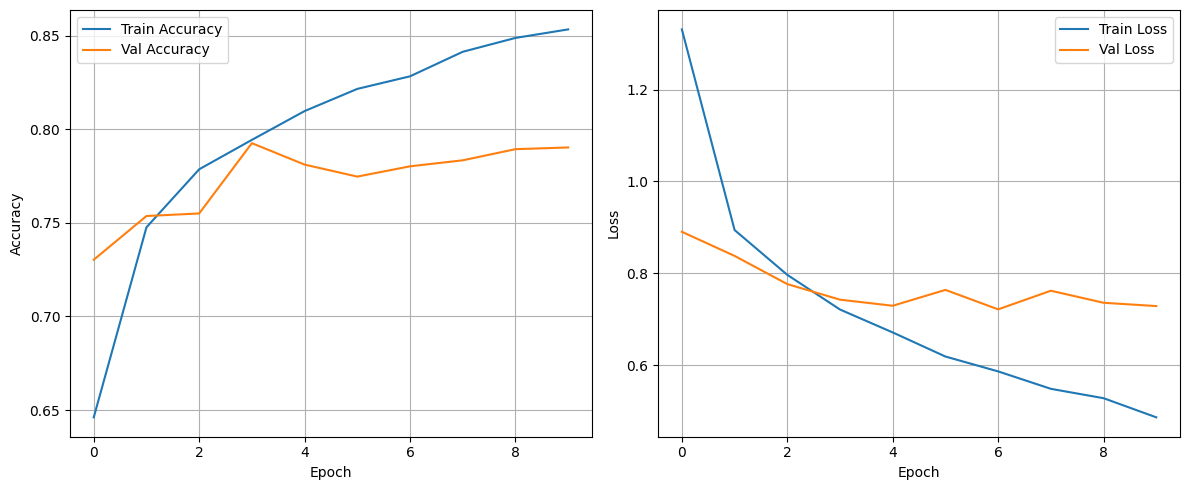

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(Model.history['accuracy'], label='Train Accuracy')
plt.plot(Model.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(Model.history['loss'], label='Train Loss')
plt.plot(Model.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**1.8 Resultados**<p>
Para evaluar el rendimiento de nuestro modelo, iniciamos el proceso de visualización comparando los datos reales (*ground truth*) con las predicciones (*predictions*) en el conjunto de prueba. Como paso inicial, identificamos y abordamos el problema potencial de variaciones en la indentación de los datos, ya que esto podría causar una comparación errónea entre las predicciones y los datos reales de imágenes distintas. Esta discrepancia podría llevar a una evaluación completamente aleatoria del modelo, comprometiendo la validez de los resultados. Por ello, implementamos medidas para garantizar una alineación correcta de los datos, asegurando una comparación precisa y una evaluación fiable del desempeño del modelo.

In [ ]:
# Reseteamos el test_generator
test_generator.reset()

# Recogemos las predicciones, las true labels, las imágenes y las probabilidades
y_pred = []
y_true = []
images = []
y_pred_probs_list = []
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

for _ in range(steps):
    x_batch, y_batch = next(test_generator)
    y_pred_probs = Model.model.predict(x_batch)
    y_pred_batch = np.argmax(y_pred_probs, axis=1)
    y_true_batch = np.argmax(y_batch, axis=1) if y_batch.ndim == 2 else y_batch
    y_pred.extend(y_pred_batch)
    y_true.extend(y_true_batch)
    images.extend(x_batch)
    y_pred_probs_list.extend(y_pred_probs)

# Pasamos a numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)
images = np.array(images)
y_pred_probs = np.array(y_pred_probs_list)
class_names = list(test_generator.class_indices.keys())

# Verificamos la longitud
print(f"Number of samples: {test_generator.samples}")
print(f"Length of images: {len(images)}")
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"Length of y_pred_probs: {len(y_pred_probs)}")
print(f"Number of classes: {len(class_names)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

**1.8.1 F1-Score**

In [ ]:
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("F1 Score (macro):", f1_macro)
print("F1 Score (weighted):", f1_weighted)

F1 Score (macro): 0.7919886383909243
F1 Score (weighted): 0.8122668215000383


**1.8.2 Matriz de Confusión**

In [ ]:
cm = confusion_matrix(y_true, y_pred)

fig = px.imshow(cm, text_auto=True, x=class_names, y=class_names, color_continuous_scale='gnbu',
                labels=dict(x='Predicted', y='True', color='Count'))
fig.update_layout(title='Matriz de Confusión Interactiva')
fig.show()

**1.8.3 Reporte de Clasificación**

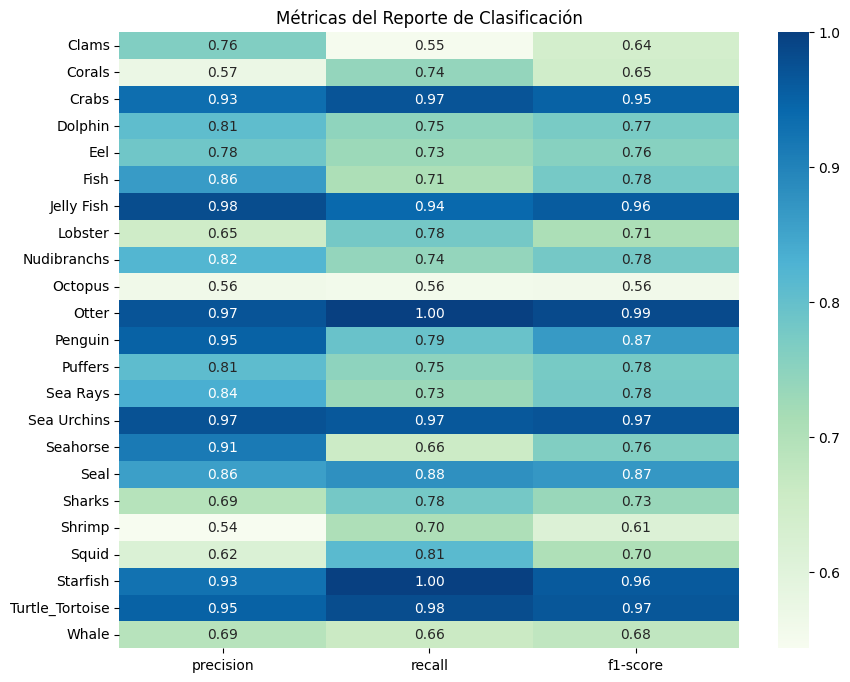

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-3, :-1]  # Exclude support and averages
plt.figure(figsize=(10, 8))
sns.heatmap(report_df, annot=True, cmap='GnBu', fmt='.2f')
plt.title('Métricas del Reporte de Clasificación')
plt.show()

**1.8.4 Ejemplos**

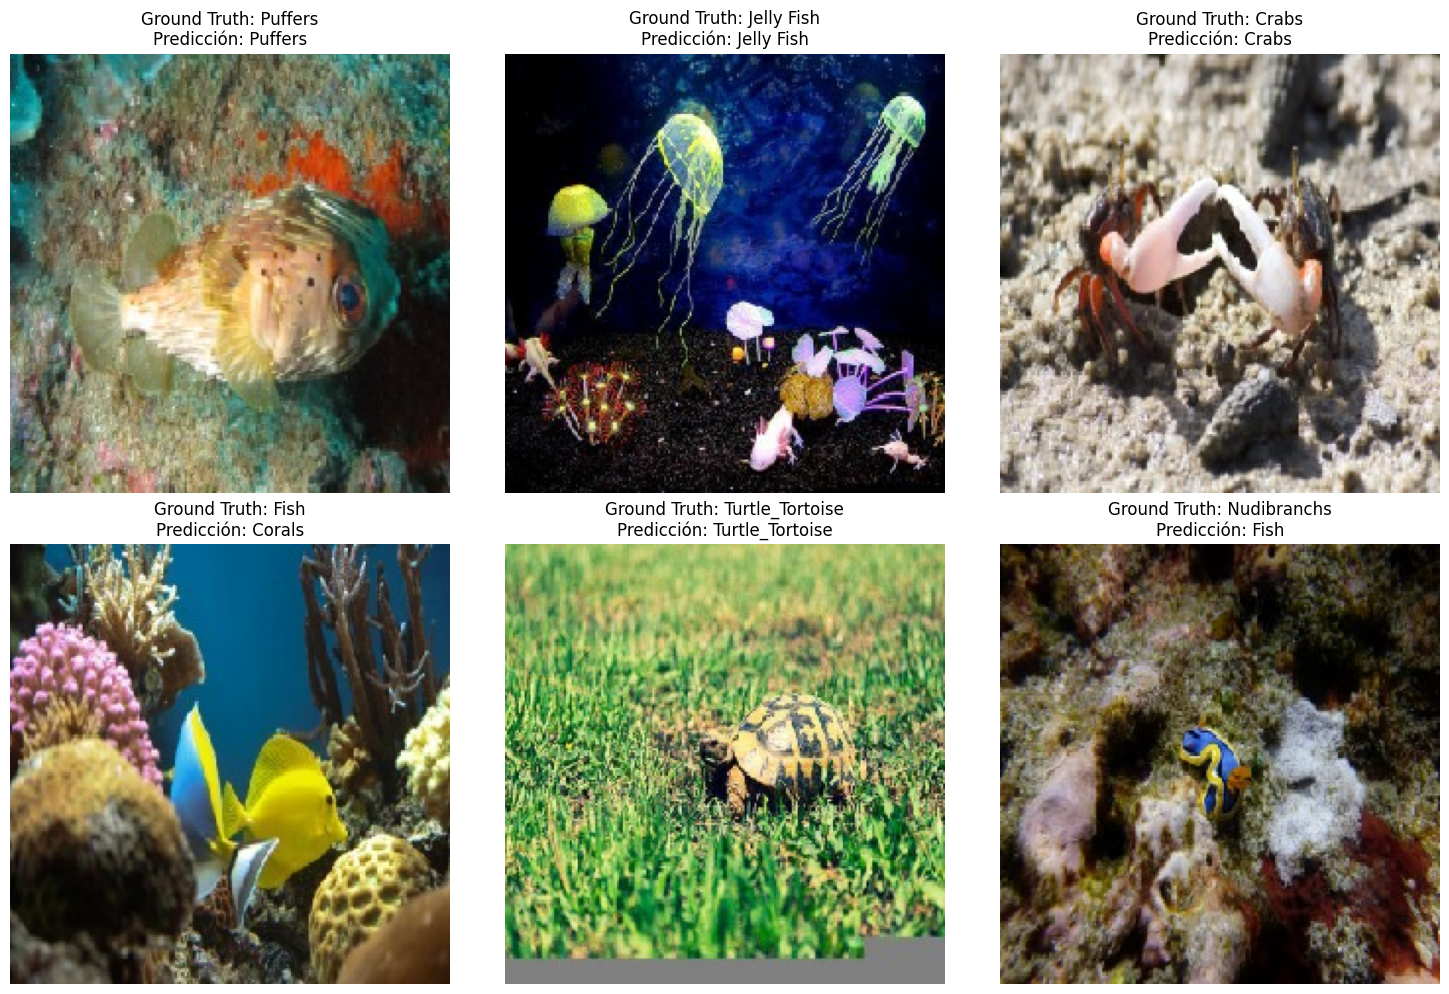

In [ ]:
num_examples = 6
plt.figure(figsize=(15, 10))

for i in range(min(num_examples, len(images))):
    plt.subplot(2, 3, i + 1)
    img = images[i]
    if img.max() > 1:
        img = img / 255.0
    plt.imshow(img)
    true_label = class_names[y_true[i]] if class_names else y_true[i]
    pred_label = class_names[y_pred[i]] if class_names else y_pred[i]
    plt.title(f"Ground Truth: {true_label}\nPredicción: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def show_image(idx):
    try:
        fig, (ax_img, ax_probs) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})

        img = images[idx] / 255.0 if images[idx].max() > 1 else images[idx]
        ax_img.imshow(img)
        true_label = class_names[y_true[idx]] if y_true[idx] < len(class_names) else f"Invalid ({y_true[idx]})"
        pred_label = class_names[y_pred[idx]] if y_pred[idx] < len(class_names) else f"Invalid ({y_pred[idx]})"
        ax_img.set_title(f"Ground Truth: {true_label}\nPredicción: {pred_label}")
        ax_img.axis('off')

        probs = y_pred_probs[idx]
        prob_text = "\n".join([f"{class_names[i]}: {p:.2f}" for i, p in enumerate(probs)])
        ax_probs.text(0.1, 0.5, prob_text, fontsize=10, va='center', ha='left', transform=ax_probs.transAxes)
        ax_probs.axis('off')
        ax_probs.set_title('Probabilidades')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error at index {idx}: {e}")

max_idx = min(len(images), len(y_true), len(y_pred), len(y_pred_probs)) - 1
interact(show_image, idx=widgets.IntSlider(min=0, max=max_idx, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=2749), Output()), _dom_classes=('widget-intera…

<function __main__.show_image(idx)>

# **Bloque 2. Resultados y Discusión**

**2.1 Modelo Base**<p>
El mejor modelo identificado para la tarea de clasificación de especies marinas fue *InceptionResNetV2*, una arquitectura híbrida que combina las fortalezas de las redes *Inception* y *ResNet*. Este modelo destaca por su capacidad para manejar imágenes complejas con múltiples características visuales, lo cual es particularmente adecuado para un conjunto de datos de especies marinas que incluye una amplia variedad de formas, texturas y colores (como peces, corales, pulpos y nutrias). La superioridad de *InceptionResNetV2* se justifica por las siguientes razones:

*   **Profundidad y Conexiones Residuales:** *InceptionResNetV2* utiliza módulos *Inception* para capturar características a diferentes escalas y conexiones residuales (inspiradas en *ResNet*) para facilitar el entrenamiento de redes profundas, reduciendo el problema del desvanecimiento del gradiente. Esto permite que el modelo aprenda representaciones más robustas de las especies marinas, incluso en presencia de variaciones intra-clase.
*   **Extracción de Características:** La arquitectura está diseñada para extraer características jerárquicas de alto nivel, lo que es crucial para distinguir entre clases con diferencias sutiles, como corales y nudibranquios, o entre especies con alta variabilidad visual, como el pulpo.
*   **Transferencia de Aprendizaje:** Al usar pesos preentrenados en *ImageNet*, *InceptionResNetV2* aprovecha conocimientos previos sobre características generales de imágenes, lo que mejora su capacidad de generalización en el dominio específico de las especies marinas.

Aunque probamos otras arquitecturas como **VGG19** (0.4968), **Xception** (0.7344), **ResNet50V2** (0.7271) e incluso una **CNN personalizada** (0.5114), **InceptionResNetV2** mostró una mayor precisión en el conjunto de validación (0,.7518) en un entrenamiento de 4 épocas. Esto puede atribuirse a su capacidad para combinar la eficiencia computacional de las redes *Inception* con la robustez de las conexiones residuales, lo que lo hace ideal para un problema con 23 clases y posibles desbalances en los datos.

**2.2 Hiperparámetros**

**2.2.1 Combinación de filtros:** Observamos que, conforme incrementamos el número de filtros, se produce una mejora en la precisión sobre el conjunto de validación. En consecuencia, posee un rendimiento superior la combinación con el mayor número de filtros (512 y 256 para las capas densas uno y dos, respectivamente). Esto obedece a que, al disponer de un mayor número de filtros, el modelo cuenta con más parámetros y, por tanto, con una mayor capacidad para representar patrones complejos. En la siguiente tabla ilustramos este comportamiento:<p>

| Filtros          | Parámetros         | Precisión en Validación |
|:----------------:|:----------------:| :----------------:|
| (64, 32)         | 2,459,744          | 0.7610            |
| (128, 64)        | 4,923,584          | 0.7592            |
| (256, 128)       | 9,863,552          | 0.7660            |
| (512, 256)       | 19,792,640         | 0.7743            |

**2.2.2 Optimizador:** *Adam* lidera en rendimiento, seguido por *Adagrad* y *SGD*. A continuación, mostramos la precisión de validación tras 4 épocas de entrenamiento:

| Optimizador          | Precisión en Validación |
|:----------------:|:----------------:|
| Adam      | 0.7647            |
| Adagrad   | 0.7340            |
| SGD       | 0.6951            |

*Adam* sobresale por integrar la base de *SGD* con un enfoque adaptativo que ajusta los gradientes dinámicamente, como detallamos en la sección 1.6.3. Esto le permite converger más rápido en muchos casos. *Adagrad*, aunque también adaptativo, es ligeramente menos eficiente en este contexto, pero se mantiene competitivo. *SGD*, más simple, queda rezagado al no incorporar adaptabilidad.


**2.2.3 Tasa de aprendizaje:** La tasa de 1e-5 alcanza la mayor precisión, lo que indica que una actualización de parámetros más conservadora favorece una convergencia estable y robusta en este escenario. La tasa de 1e-4, aunque próxima, no logra igualar este rendimiento, sugiriendo que un ajuste ligeramente más rápido sacrifica precisión en favor de velocidad. Por su parte, la tasa de 1e-3 muestra una caída significativa, probablemente debido a pasos de optimización excesivos que generan inestabilidad en el proceso de entrenamiento.

| Learning Rate          | Precisión en Validación |
|:----------------:|:----------------:|
| 1e-5       | 0.7788            |
| 1e-4       | 0.7679            |
| 1e-3       | 0.7326            |

Estos resultados son notables, ya que se podría anticipar que tasas de aprendizaje bajas serían más efectivas en entrenamientos prolongados. No obstante, tras solo 4 épocas, la superioridad de las tasas de aprendizaje reducidas es evidente, destacando su capacidad para lograr una convergencia precisa y estable en un tiempo limitado.

**2.3 Las Especies Marinas más Únicas**<p>
En el desarrollo de nuestro proyecto de clasificación de imágenes de especies marinas, hemos constatado patrones significativos en el rendimiento del modelo al analizar las 23 clases presentes en el conjunto de datos, apoyándonos en las métricas de precisión, *recall* y *F1-score* obtenidas. Entre las especies evaluadas, hemos identificado que la nutria, conocida en inglés como *otter*, se destacó como la más fácilmente clasificable, con un rendimiento excepcional reflejado en una precisión de 0.97, un *recall* de 1.00 y un *F1-score* de 0.99. Consideramos que esta observación se fundamenta en las características visuales distintivas y consistentes que presenta esta especie, tales como un cuerpo alargado, un pelaje característico de tonalidad uniforme y patrones de comportamiento singulares, como su tendencia a flotar boca arriba en la superficie del agua, los cuales permiten diferenciarlas con claridad de otras especies marinas incluidas en el conjunto de datos, como peces, corales o moluscos. Además, hemos observado que las imágenes de nutrias suelen capturarse en entornos de relativa simplicidad visual, con fondos menos complejos que los habituales en contextos submarinos, lo que facilita la extracción de características relevantes por parte del modelo y contribuye a la alta precisión y *recall* registrados, indicando una mínima incidencia de falsos positivos.<p>
Por otro lado, hemos constatado que el pulpo, denominado *octopus* en inglés, presentó el mayor desafío para el modelo, con métricas notablemente más bajas que reflejan las dificultades encontradas: una precisión de 0.56, un *recall* de 0.56 y un *F1-score* de 0.56, lo que lo posiciona como la clase con el peor desempeño en el reporte de clasificación. Este resultado lo atribuimos a la alta variabilidad en formas, colores y texturas que caracterizan a los pulpos, quienes poseen la capacidad de cambiar de color para camuflarse, adoptar formas diversas al moverse y presentar tentáculos que, en muchas imágenes, pueden confundirse con estructuras de otras especies, como corales o anémonas. Esta variabilidad intra-clase, combinada con posibles similitudes visuales con otras clases, como los calamares (*squid*), que obtuvieron un *F1-score* de 0.70, probablemente resultó en una mayor tasa de errores de clasificación, como se evidencia en las métricas mencionadas.

# **Bloque 3. Aprendizajes**

**3.1 Transferencia de Aprendizaje**<p>
Uno de los aprendizajes fundamentales que hemos obtenido radica en la comprensión del significativo potencial del *transfer learning*, específicamente en su variante de *inductive transfer learning*. Este enfoque se refiere a la capacidad de abordar una tarea de clasificación específica, como la identificación de 23 clases de especies marinas, aprovechando el conocimiento adquirido por un modelo durante un entrenamiento previo en una tarea de clasificación general, como la realizada en un conjunto de datos amplio y diverso como *ImageNet*. Hemos constatado que esta estrategia nos permitió canalizar las representaciones generales aprendidas por el modelo preentrenado hacia un dominio más especializado, optimizando el rendimiento en la identificación de animales marinos específicos.<p>
Este hallazgo no llegó lógicamente sin antes probar a entrenar los modelos grandes (*VGG19*, *Xception*, *ResNet50V2* e *InceptionResNetV2*) desde cero. Mediante esta estrategia dónde obviamos la transferencia de aprendizaje, no alcanzamos en el mejor de los casos el 0.12 de precisión en el conjunto de validación.

**3.2 Recursos Computacionales**<p>
Durante este trabajo, hemos podido observar que los modelos base preentrenados se entrenaban en un tiempo de computación similar, por no decir idéntico, independientemente de la cantidad de pesos que cada uno poseía. Este hallazgo resulta notable al observar que *InceptionResNetV2*, el modelo óptimo identificado, cuenta con aproximadamente 10 veces más pesos que otros modelos cómo *Xception* y, sin embargo, ambos exhibieron tiempos de entrenamiento comparables en nuestro entorno de *Google Colab*, un resultado que se traduce en un coste computacional eficiente para todos los modelos probados.<p>
Esto se debe a la optimización inherente de estas arquitecturas y al uso de técnicas como *ImageDataGenerator* para manejar los datos en lotes, lo que minimiza el impacto del número de parámetros en el entrenamiento.

# **Bloque 4. Líneas Futuras**

**4.1 Capas Densas del Clasificador**<p>
En el desarrollo de nuestro proyecto, hemos identificado que una estrategia común para optimizar el rendimiento de un modelo consiste en ajustar el número de capas densas del clasificador, un enfoque que permite al modelo capturar relaciones más complejas entre las características extraídas y las clases objetivo. En el trabajo realizado, nuestro esfuerzo se ha centrado principalmente en la identificación del modelo base óptimo y en el subsiguiente ajuste fino (*fine-tuning*) de hiperparámetros, como el tamaño de las capas densas (512 y 256 unidades), la tasa de aprendizaje y el uso del optimizador *Adam*, lo que nos permitió alcanzar un rendimiento competitivo, como se refleja en el reporte de clasificación.<p>
Sin embargo, hemos constatado que aún existe un margen significativo de mejora. Por ello, hemos considerado que un enfoque prometedor para futuros trabajos sería aumentar el número de capas densas del clasificador, por ejemplo, incorporando una tercera capa densa con 128 unidades, lo que podría permitir al modelo capturar relaciones más complejas entre las características de alto nivel y mejorar su capacidad para diferenciar entre clases visualmente similares. Este ajuste, al incrementar la capacidad del clasificador para modelar patrones específicos del dominio marino, probablemente conduciría a una mayor tasa de acierto, especialmente en categorías donde el rendimiento actual es subóptimo.

**4.2 Localización en la Imagen**<p>
Consideramos relevante la implementación de técnicas avanzadas de visión computacional que vayan más allá de la mera clasificación, específicamente en lo que respecta a la localización de las especies dentro de las imágenes, una tendencia actual que ha ganado gran importancia en este campo. Consideramos que determinar su posición precisa dentro de la imagen mediante el uso de *bounding boxes* o incluso *oriented bounding boxes*, enriquecería significativamente la funcionalidad del modelo. Este enfoque resultaría particularmente útil en nuestro contexto, donde las imágenes marinas a menudo presentan fondos complejos que dificultan la identificación de especies como el pulpo (*octopus*), cuya clasificación alcanzó un *F1-score* de 0.56, uno de los más bajos según el reporte de clasificación.

Hemos identificado que un algoritmo ampliamente reconocido para este propósito es *YOLO* (*You Only Look Once*), desarrollado por [Ultralytics](https://www.ultralytics.com/), el cual destaca por su simplicidad e intuitividad en la implementación. *YOLO* se basa en un enfoque de detección de objetos que procesa la imagen en una sola pasada, dividiéndola en una cuadrícula y prediciendo simultáneamente las coordenadas de los *bounding boxes*, las probabilidades de clase y la confianza de las detecciones para cada celda de la cuadrícula, lo que lo hace excepcionalmente eficiente en términos de velocidad y precisión.